## EPSP analysis for Ih
The epsp analysis as done in the Sunstrum paper is partially built into the package (under `pyAPisolation.dev.epsp_analysis`). However, I have attempted to make this script as externalized as possible. The complete script can be found in this folder as `EPSP_ANALYSIS_batch.py`



### Data setup

Similar to the other analysis scripts - this script expects the data in the form of numpy arrays with the structure `[sweeps, time points]`. In this case, we need the x, y, c arrays for the response cell. 
Unfortunately due to the limitations of how clampex/clampfit handles custom stims, we also need to pass in the x, y, c arrays for the stimulus.

So in total we will need six arrays:
- f_x : The time array (in seconds)
- f_y : The voltage response array (in mV)
- f_c : The applied stimuli (in pA) (in this case unused)
- stim_x : The time array for the stimulus
- stim_y : The applied stimuli (in pA)
- stim_c : unused, but for consistency

below we will load some demo data and plot it.

(17, 100000) (17, 100000) (17, 100000) (17, 100000) (17, 100000) (17, 100000)


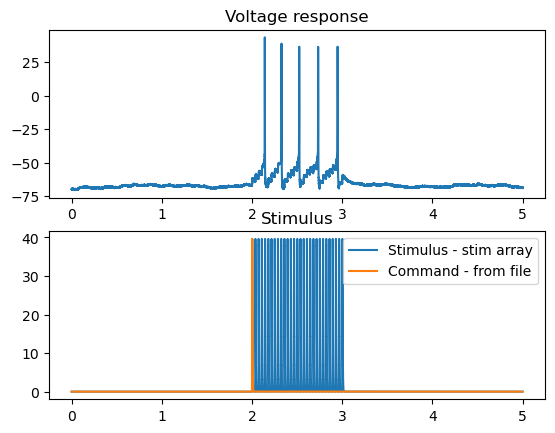

In [1]:
#needed for array opening
import numpy as np
import matplotlib.pyplot as plt
#load the demo_data
demo_data  = np.load(".\\data\\2021_09_23_0037.npz", allow_pickle=True)
f_x, f_y, f_c, stim_x, stim_y, stim_c = demo_data['f_x'], demo_data['f_y'], demo_data['f_c'], demo_data['stim_x'], demo_data['stim_y'], demo_data['stim_c']

print(f_x.shape, f_y.shape, f_c.shape, stim_x.shape, stim_y.shape, stim_c.shape)
plt.subplot(2,1,1)
plt.plot(f_x[-1], f_y[-1])
plt.title('Voltage response')
plt.subplot(2,1,2)
plt.plot(stim_x[-1], stim_y[-1], label='Stimulus - stim array')
plt.plot(f_x[-1], f_c[-1], label='Command - from file') #you can see, not loaded properly its all the same
plt.title('Stimulus')
plt.legend()

### EPSP ANALYSIS function
Now we can run the main `run_analysis` on this data. This function takes in the arrays, runs the various analysis, and returns a dict of the properties. For indepth explanation of what its doing check out the `epsp_analysis_indepth.ipynb` notebook in the same folder.
Here is the call signature:
```python
def run_analysis(f_x, f_y, f_c, stim_x, stim_y, stim_c, stim_scale_factor=1, line_baseline=True, compute_inst_freq=True, mask_spikes=True, plot=False, mask_sweeps=False):
    """Run EPSP analysis over arrays of data. In this case, since we are doing unpaired analysis, the stim and response are passed in as separate arrays.

    Args:
        f_x (np.array): time axis of the voltage response
        f_y (np.array): voltage response data
        f_c (np.array): current command data
        stim_x (np.array): time axis of the stimulus
        stim_y (np.array): stimulus data
        stim_c (np.array): stimulus current data
        line_baseline (bool, optional): Applies linear regression to baseline the sweep,
                                        accounting for voltage drift. Defaults to True.
        compute_inst_freq (bool, optional): Compute the inst. freq. response for each sweep. 
                                            Takes a long time and can be disabled. Defaults to True.
        mask_spikes (bool, optional): Masks the spikes in the response. Defaults to True.
        plot (bool, optional): plot the gathered data. Defaults to False.
        mask_sweeps (bool, optional): Masks the sweeps that have a variance ratio greater than 1.5. Defaults to False.

    Returns:
        dict: containing the resp means and FFT data
    

    """
```
Here we have a few additional args:
- `line_baseline` applies a linear regression to baseline the data - this is useful if you have a strong voltage drift that may skew the measurement of summation. This baseline does not apply to the stimulation times, so it should avoid skewing the actual summation measurements.
- `compute_inst_freq` uses elephant package to compute the inst. freq. of the stim and response. This is useful if you have something like a poission sampled stim.
- `mask_spikes` this masks the spikes when computing the subthreshold summation to avoid skewing the data.
- `mask_sweeps` this masks sweeps that fail a variance QC. Useful for in vitro data that is noisy.

The return dict contains the following:
```python
#return the results as a dict for easy usage
dict_return = {"f_stim":f_stim, #the inst. freq. of the stimulus
    "f_resp":f_resp, #the inst. freq. of the response
    "f_resp_mean":f_resp_mean, #the mean inst. freq. of the response
    "x_data":x_data,  #the x data for the mean
    "sweep_wise_offset":sweep_wise_offset,  #the offset (exp decay fit) of the response
    "sweep_wise_offset_params_mean": sweep_wise_offset_params_mean,  #the offset (exp decay fit) params of the response
    "sweep_wise_offset_params_dict": sweep_wise_offset_params_dict,  #the offset (exp decay fit) params of the response for each sweeo
    "sweepwise_hz":sweepwise_hz, #the overall stim freq per sweep
    "f_sweepwise_resp":f_sweepwise_resp,  #the overall response per sweep
    "fft_x":fft_x, #the fft x data
    "fft_resp":fft_resp,#the fft response
    "sweepwise_peak_mean": sweep_wise_peak_mean, #mean (+/- 10 points) the absolute peak response per sweep
    "sweepwise_peaks_raw": sweep_wise_peaks_raw, #the raw peak responses per sweep
    "peak_wise_means": peak_wise_means_raw, #the mean of each peak across sweeps e.g we mean across all sweeps the first peak, second peak, etc.
    'sweepwise_auc':sweep_wise_auc, #the area under the curve of the response per sweep
    'qc_metrics':qc_metrics_dict, #the qc metrics of the recording
    'meta_data':meta_data, #the metadata of the recording
    'spike_features':spike_features, #the spike features
    'spike_time':spike_time}  #the spike times
```


In [4]:

from pyAPisolation.dev.epsp_analysis import run_analysis
dict_out = run_analysis(f_x, f_y, f_c, stim_x, stim_y, stim_c, plot=False)


m:\Users\SMest\source\repos\smestern\pyAPisolation\pyAPisolation\dev\epsp_analysis.py:299: RuntimeWarning: Mean of empty slice
  f_resp.append(np.nanmean(fyb[sweep, idx_to_use][fyb[sweep, idx_to_use]>0]))
c:\ProgramData\miniconda3\envs\modelling\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
c:\ProgramData\miniconda3\envs\modelling\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = phi / phi_prime
c:\ProgramData\miniconda3\envs\modelling\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: divide by zero encountered in scalar divide
  p *= Delta / norm(p)
c:\ProgramData\miniconda3\envs\modelling\lib\site-packages\scipy\optimize\_lsq\common.py:166: RuntimeWarning: invalid value encountered in multiply
  p *= Delta / norm(p)
c:\ProgramData\miniconda3\envs\modelling\lib\site-packages\scipy\optimize\_

dict_keys(['f_stim', 'f_resp', 'f_resp_mean', 'x_data', 'sweep_wise_offset', 'sweep_wise_offset_params_mean', 'sweep_wise_offset_params_dict', 'sweepwise_hz', 'f_sweepwise_resp', 'fft_x', 'fft_resp', 'sweepwise_peak_mean', 'sweepwise_peaks_raw', 'peak_wise_means', 'sweepwise_auc', 'qc_metrics', 'meta_data', 'spike_features', 'spike_time'])
{'a_mean': 5.4981466364881655, 'tau_mean': 0.0908300994145097, 'c_mean': -0.3070795859558434}


In [8]:
#here is the output dictionary
for k in dict_out.keys():
    print(k, type(dict_out[k]), end=' ')
    try:
        print(dict_out[k].shape)
    except:
        print(dict_out[k])

f_stim <class 'numpy.ndarray'> (170,)
f_resp <class 'numpy.ndarray'> (170,)
f_resp_mean <class 'numpy.ndarray'> (8,)
x_data <class 'numpy.ndarray'> (8,)
sweep_wise_offset <class 'list'> [array([ 4.2925,  3.8958,  4.201 , ..., -0.007 ,  0.4507, -0.0375]), array([ 2.9901,  2.7459,  3.1426, ..., -0.0322,  0.3035, -0.1238]), array([ 4.5908,  4.9875,  4.5603, ..., -1.0417, -0.7671, -1.1028]), array([ 2.878 ,  2.756 ,  2.9696, ..., -0.5089, -0.631 , -0.5394]), array([ 3.685 ,  3.7766,  4.0513, ..., -0.5984, -0.3848, -0.1711]), array([ 6.0676,  6.2507,  5.915 , ..., -0.5428, -0.4207, -0.1461]), array([ 5.1884,  5.0053,  5.341 , ..., -0.4968, -0.8935, -0.6798]), array([ 3.249 ,  2.7912,  3.0354, ..., -0.6319, -0.7845, -0.4183]), array([5.7334, 5.7029, 5.3672, ..., 1.2344, 1.2649, 0.9902]), array([ 4.051 ,  3.8068,  3.9289, ..., -0.2531, -0.0395, -0.5278]), array([5.7388, 5.4031, 5.7387, ..., 0.9406, 1.3373, 1.0321]), array([10.2098,  9.8741,  9.752 , ..., -0.141 , -0.3546, -0.5987]), array([9.